In [ ]:
# RFC predicts variability labels from input set (basic stellar prop.)

In [2]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pushkin.train import train_rf
from pushkin.classify import classify
from os import path
from tqdm import tqdm

In [34]:
df = pd.read_csv("../output/rf_inp.csv")
vt = pd.read_csv("../output/rf_labels.csv")

In [ ]:
len(df)

2451

In [37]:
len(vt)

150605

In [35]:
# rf

x_labelled = df # no flux data, only prop
y_labelled = vt

x = x_labelled.iloc[:, 1:]
y = y_labelled.iloc[:, 1:]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_t = sc.fit_transform(x_train)
x_test_t = sc.transform(x_test)
x_val_t = sc.transform(x_val)

# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=100, max_features='sqrt')
rf.fit(x_train_t, y_train)

importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
print(importances)

# Evaluating the model
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error, explained_variance_score

print("Train score: " + str(explained_variance_score(rf.predict(x_train_t), y_train)))
print("Test score: " + str(explained_variance_score(rf.predict(x_test_t), y_test)))
print("Validation score: " + str(explained_variance_score(rf.predict(x_val_t), y_val)))
# print("Out-of-bag score: " + str(rf.oob_score_))

ValueError: Found input variables with inconsistent numbers of samples: [2451, 150605]

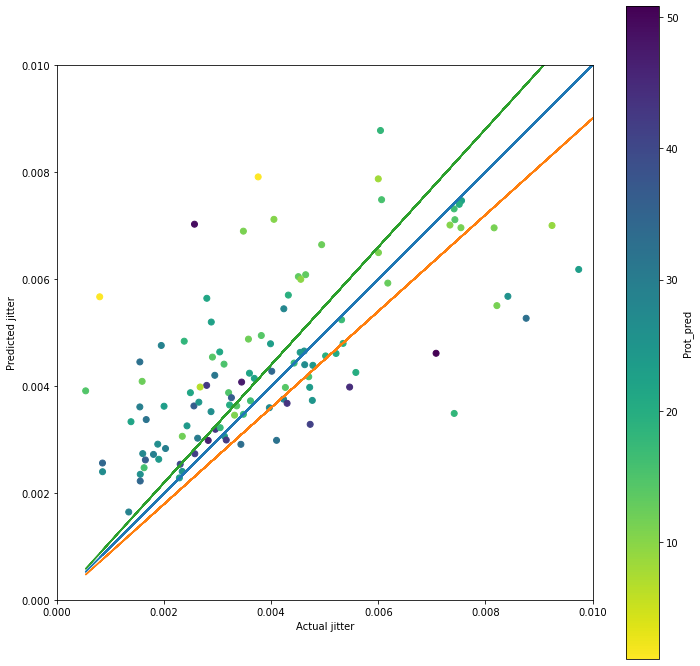

Score: 0.5666362541942793


In [163]:
# Plot actual vs predicted variability (change label for stdev / jitter) - validation set only

label = 'Jitter' # Standard_Deviation # Jitter

x_vis = x_val
y_vis = y_val

x_plot = y_vis[label].tolist()
y_plot = rf.predict(sc.transform(x_vis))

plt.figure(figsize=(12, 12)) 

# plt.loglog()

scatter = plt.scatter(x_plot, y_plot, c=x_vis['Prot_pred'], cmap='viridis_r')
cbar = plt.colorbar()
cbar.set_label('Prot_pred')

plt.axis('square')
plt.xlim(0, 0.01)
plt.ylim(0, 0.01)
plt.xlabel('Actual jitter')
plt.ylabel('Predicted jitter')

# within 10% of actual value
plt.plot(x_plot, x_plot)
plt.plot(x_plot, list(map(lambda x : 0.9 * x, x_plot)))
plt.plot(x_plot, list(map(lambda x : 1.1 * x, x_plot)))

plt.show()

print("Score: " + str(r2_score(rf.predict(sc.transform(x_vis)), y_vis)))

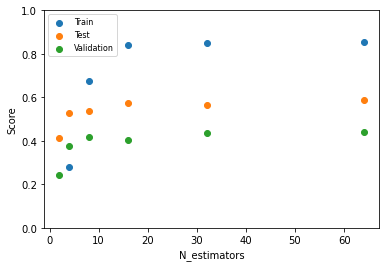

In [160]:
# Plot test vs val score based on max_depth

param=[2, 4, 8, 16, 32, 64, None]
train = []
test = []
val = []

for x in param:
    rf = RandomForestrf(n_estimators=100, max_depth=x, max_features='sqrt', min_samples_split=3)
    rf.fit(x_train_t, y_train)
    train.append(r2_score(rf.predict(x_train_t), y_train))
    test.append(r2_score(rf.predict(x_test_t), y_test))
    val.append(r2_score(rf.predict(x_val_t), y_val))    

train_plot = plt.scatter(param, train)
test_plot = plt.scatter(param, test)
val_plot = plt.scatter(param, val)

plt.legend((train_plot, test_plot, val_plot),
           ('Train', 'Test', 'Validation'),
           scatterpoints=1,
           loc='best',
           fontsize=8)

# plt.xlim(0, 22)
plt.ylim(0, 1)
plt.xlabel('N_estimators')
plt.ylabel('Score')

plt.show()

In [ ]:
# Cross validation tuning of hyperparameters for RFR

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestrf
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestrf(),
        param_grid={
            "n_estimators":[5,10,50,100,250,500],
            'max_features': ['sqrt', 'log2', None],
            "max_depth":[2, 4, 8, 16, 32, None],
            "min_samples_split": [2, 5, 10, 50, 100, 250, 500]
        },
        cv=10, scoring='r2', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    print(best_params)
    
    rfr = RandomForestrf(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=0, verbose=False)

    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=5, scoring='r2')
    print(scores)
    print(np.mean(scores))

rfr_model(x_val_t, y_val['Jitter'])

In [ ]:
n_train = 1
abspath = path.abspath ('..') + '/Pushkin/'
classify_missing = False

PATH_OUT_CLASSIFIER = abspath + 'data/rf_storage/'
PATH_SAMPLES = abspath + '/data/input_samples/'
file_train = 'kepler_km_sample.csv'

file_flag = 'kepler_km_full_flag.csv'
PATH_OUT = abspath + 'data/results_training/filter/'
fileout_result = 'run_' + str(ii+1) + '_km_filter_frame.csv'


# SWITCH TO TRUE TO SAVE THE SUMMARY FRAME AND THE CLASSIFIER
summary = True
save = True
plot = True # will show only the first plot not to overhelm the notebook

class_weight = 'balanced'
test_size = 0.25
clf = train_rf (df, clf_name=PATH_OUT_CLASSIFIER+fileout_classifier, frame_name=PATH_OUT+fileout_result,
        n_estimators=300, criterion='gini', min_samples_split=2, plot=plot,
        class_weight=class_weight, test_size=test_size, summary=summary, save=save, random_state=ii, verbose=1)
